# Monte Carlo Simulations
### Import the necessary packages

Enter the number of spatial units:4
No of timepoints: 50
No of Replications: 1


C:\Users\Elkanah\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Average parameter values across replications for n=4
           Estimate  True Param          Bias           MAE    RMSE     R_MAE
Param                                                                        
beta_1       3.0399         3.0  3.993394e-02  3.993394e-02  0.0399  0.013311
beta_2      -0.0171         0.0 -1.714959e-02  1.714959e-02  0.0171       NaN
beta_3       1.9073         2.0 -9.272892e-02  9.272892e-02  0.0927  0.046364
phi_1        0.0000         0.0  6.184626e-12  6.184626e-12  0.0000       NaN
phi_2        0.3208         0.3  2.082710e-02  2.082710e-02  0.0208  0.069424
phi_3        0.3229         0.3  2.294172e-02  2.294172e-02  0.0229  0.076472
phi_4        0.2535         0.3 -4.647730e-02  4.647730e-02  0.0465  0.154924
W_1          0.2227         0.2  2.265007e-02  2.265007e-02  0.0227  0.113250
W_2          0.0939         0.2 -1.060938e-01  1.060938e-01  0.1061  0.530469
W_3          0.2886         0.2  8.860273e-02  8.860273e-02  0.0886  0.443014
W_4        

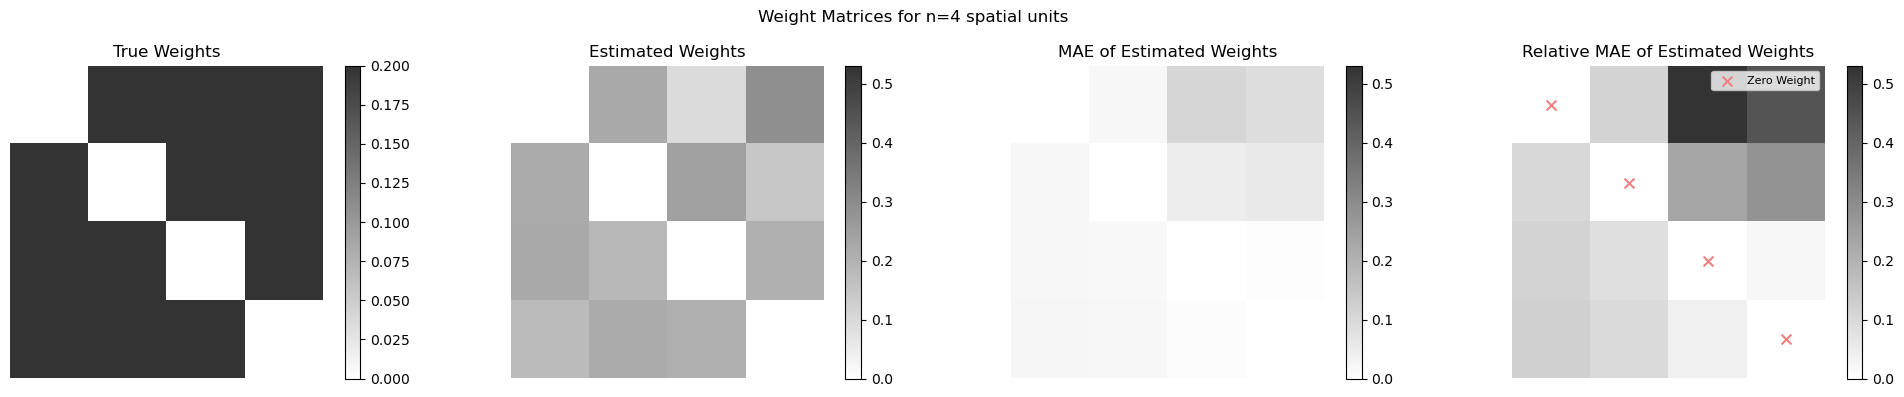

In [54]:
##########################################################################################################################
import os
import csv
import time
import numpy as np
import pandas as pd
import math
import scipy.sparse as sp #Provides functions and classes to work efficiently with sparse matrices
from libpysal.weights import lat2W #creates spatial weights for a regular lattice/grid
from scipy.linalg import solve
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import itertools
import concurrent.futures
import matplotlib.colors as mcolors
from memory_profiler import profile
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
#########################################################################################################################
#########################################################################################################################
# Set working directory
os.chdir('C:\\Users\\Elkanah\\Desktop\\Elkanah\\STAR_LASSO')
##########################################################################################################################
# -----------Parameter initialization ------------------------------------------- 
while True:
    n = int(input("Enter the number of spatial units:"))
    if n > 0 and math.isqrt(n)**2 == n:
        break  # valid perfect square
    print("Invalid input! Please enter a perfect square number so a square grid can be created.")
#---------------------------------------------------------------------------------
Time = int(input("No of timepoints: ")) 
#------------create the weights matrix-Queens contiguity---------------------------
WM = np.array(lat2W(int(np.sqrt(n)), int(np.sqrt(n)), rook=False).full()[0],dtype=float)  # Create Queen contiguity weights and convert to a numpy matrix
np.fill_diagonal(WM, 0)
WM = WM / WM.sum(axis=1, keepdims=True) # Row-normalize
# np.save(f"RESULTS/WM{n}.npy", WM) # Save the weights
#---------------Load the weight matrix and plot --------------------------------------------
#WM = np.load(f"RESULTS/WM{n}.npy") # Load the weights
# cmap_gray = mcolors.LinearSegmentedColormap.from_list("custom_gray", [(1,1,1),(0.2,0.2,0.2)])
# plt.imshow(WM, cmap=cmap_gray, interpolation='none')
# plt.title(f"Spatial Weights matrix, n={n}")
# plt.colorbar(label="Weight")
# plt.axis('off')  # hide axes
# plt.show()
#---------initialize other parameters------------------------------------------------
num_replications = int(input("No of Replications: ")) 

beta = np.array([3, 0, 2])
k = len(beta)
phi = np.array([0] * int(n * 0.25) + [0.3] * (n - int(n * 0.25))) #Temporal coefficient
rho = 0.6   #spatial autoregressive coefficient
A = np.linalg.inv(np.eye(n) - rho * WM) #Find the inverse of (I-W)
parameters = np.concatenate((beta, phi, rho * WM[np.triu_indices(WM.shape[0], k=1)], rho * WM[np.tril_indices(WM.shape[0], k=-1)],[1], [np.nan,np.nan,np.nan,np.nan,np.nan]))
#-----------------------------------------------------------------------------------------
#=========================================================================================
#-----------------Define the Log-Likelihood function--------------------------------------
def Likelihhod_STAR(parameters, Y, X, n, k, Time, lambda1, lambda2, lambda3):
    #---- Extract the parameters------
    beta = parameters[:k]
    phi = parameters[k:k+n]
    Weights = parameters[int(k+n):int(k+n+n*(n-1))]
    sigma2_eps = parameters[int(k+n+n*(n-1))]
    if sigma2_eps <= 0:
        return 1e10
    #--------Construct W --------------------------------------
    W = np.zeros((n, n))
    W[np.triu_indices(n, k=1)] = parameters[int(k+n):int(k+n+n*(n-1)//2)]
    W[np.tril_indices(n, k=-1)] = parameters[int(k+n+n*(n-1)//2):int(k+n+n*(n-1))]
   
    # --- Spectral radius condition ---
    try:
        eigvals = np.linalg.eigvals(W)
        if np.max(np.abs(eigvals)) >= 1:
            return 1e10
    except:
        return 1e10
    #-------------------------------------------------------------
    # ----Log-determinant stability --------
    try:
        sign, logdet = np.linalg.slogdet(np.eye(n) - W)
        if sign <= 0 or not np.isfinite(logdet):
            return 1e10
    except:
        return 1e10
    #------------Full stability condition-------------------------------------------
    try:
        A = np.linalg.inv(np.eye(n) - W)
        # infinity norm = max_i sum_j |A_ij| |phi_j|
        row_sums = np.sum(np.abs(A) * np.abs(phi), axis=1)

        if np.max(row_sums) >= 1:
            return 1e10

    except:
        return 1e10
    #----------------------------------------------------------------------------- 
    #------and compute the residuals----------------------------------------------------------------------------------
    residuals = Y[:, 1:] - (W @ Y[:, 1:] + X[:, 1:, :] @ beta + phi[:, np.newaxis] * Y[:, :-1]) #Vectorised
    sum_of_squares = np.sum(residuals**2) / sigma2_eps
    #----------------------------------------------------------------------
    # Penalised log-likelihood
    Constant_term = -0.5 * (Time - 1) * n* (np.log(2 * np.pi) + np.log(sigma2_eps)) + (Time - 1) * np.linalg.slogdet(np.eye(n) - W)[1]
    LogLik = Constant_term - (0.5 * sum_of_squares) - (lambda1*np.sum(np.abs(beta)) + lambda2*np.sum(np.abs(phi)) + lambda3*np.sum(np.abs(Weights)))
    return -LogLik
#=========================================================================================
#------------- Constraint function for W------------------
def constraint_func(param, n, k):
    W = np.zeros((n, n))
    W[np.triu_indices(n, k=1)] = param[int(k+n):int(k+n+n*(n-1)//2)]
    W[np.tril_indices(n, k=-1)] = param[int(k+n+n*(n-1)//2):int(k+n+n*(n-1))]
    row_sums = np.sum(np.abs(W), axis=1)
    return 1 - row_sums  # Constraint: row_sums <= 1
##########################################################################################################################
# --------Perform cross-validation for all lambda combinations-----
def cross_validate_lambda_combination(X, Y, n, k, Time, param, bounds, num_folds=5):
    lambda_values1 = np.concatenate(([0], np.logspace(-1, 0, 9)))
    lambda_values2 = np.concatenate(([0], np.logspace(-1, 0, 9)))
    lambda_values3 = np.concatenate(([0], np.logspace(-1, 0, 9)))
    lambda_combinations = np.array(list(itertools.product(lambda_values1, lambda_values2, lambda_values3))) #List of lambda combinations
    #----------------------------------------------------------
   
    Av_RMSE = np.zeros((len(lambda_values1), len(lambda_values2), len(lambda_values3)))  # Array to store average RMSE values for each lambda combination

    block_size = Time // num_folds
    #---------------- Cross-validation for 1 lambda combination------------------------------------
    def cross_validate_lambda(lambdas):
        folds_rmse_list = [] 
        for fold in range(num_folds):
            start = fold * block_size
            end = (fold + 1) * block_size if fold < num_folds - 1 else Time
            #--------------------------------------------------------------
            test_indices = np.arange(start, end)
            train_indices = np.setdiff1d(np.arange(Time), test_indices)
            X_train = X[:, train_indices]
            Y_train = Y[:, train_indices]
            X_test = X[:, test_indices]
            Y_test = Y[:, test_indices]
            #--------------------------------------------------------------------
            result = minimize(Likelihhod_STAR,param,args=(Y_train, X_train, n, k, len(train_indices),lambdas[0], lambdas[1], lambdas[2]),
                method='SLSQP',bounds=bounds,constraints={'type': 'ineq','fun': lambda x: constraint_func(x, n, k)})
            ##-----retrieve optimised parameters---------------------------------------------------------------
            parameters_opt = result.x
            betas_opt = parameters_opt[:k]
            phis_opt = parameters_opt[k:k + n]
            W_opt = np.zeros((n, n))
            W_opt[np.triu_indices(n, k=1)] = parameters_opt[int(k + n):int(k + n + 0.5 * n * (n - 1))]
            W_opt[np.tril_indices(n, k=-1)] = parameters_opt[int(k + n + 0.5 * n * (n - 1)):int(k + n + n * (n - 1))]
            #--------Prediction------------------------------------------------------------
            Y_pred = np.zeros((n, len(test_indices)))
            Aopt = np.linalg.inv(np.eye(n) - W_opt)
            for t in range(1, len(test_indices)): #At t=1, we ignore the lag
                if t == 1:
                    Y_pred[:, t] = np.dot(Aopt, (np.dot(X_test[:, t, :], betas_opt)))
                else:
                    Y_pred[:, t] = np.dot(Aopt, (np.dot(X_test[:, t, :], betas_opt) + phis_opt * Y_pred[:, t-1]))

            rmse = np.sqrt(np.mean((Y_pred - Y_test) ** 2))
            folds_rmse_list.append(rmse)
        return np.mean(folds_rmse_list)
    ## --------- Parallel over lambda combinations only ---------
    with concurrent.futures.ThreadPoolExecutor() as executor:

        lambda_results = list(
            executor.map(cross_validate_lambda, lambda_combinations)
        )

    # Store results
    for i, lambdas in enumerate(lambda_combinations):

        lambda1, lambda2, lambda3 = lambdas
        ind1 = np.where(lambda_values1 == lambda1)[0][0]
        ind2 = np.where(lambda_values2 == lambda2)[0][0]
        ind3 = np.where(lambda_values3 == lambda3)[0][0]

        Av_RMSE[ind1, ind2, ind3] = lambda_results[i]

    return Av_RMSE, lambda_combinations, lambda_values1, lambda_values2, lambda_values3
#=========================================================================================
#=========================================================================================
# Function for replication simulation
def replication_simulation(replication_id, Time):
    np.random.seed(replication_id)
    start_time = time.time()
    #print(f'Simulation {replication_id + 1} has started')
    Time = Time
    XVar = np.random.normal(0, 1, size=(n, Time + 100, k))
    eps = np.random.normal(size=(n, Time + 100))
    Yo = np.random.normal(0, 1, size=n)
    YVar = np.zeros((n, Time + 100))
    
    for t in range(1, Time + 100):
        if t == 1:
            YVar[:, t] = np.dot(A, (np.dot(XVar[:, t, :], beta) + phi * Yo + eps[:, t]))
        else:
            YVar[:, t] = np.dot(A, (np.dot(XVar[:, t, :], beta) + phi * YVar[:, t-1] + eps[:, t]))

    Y = YVar[:, 100:]
    X = XVar[:, 100:, :]
    param = np.concatenate((np.ones(k), np.repeat(0.1, n), np.repeat(0.001, int(n*(n-1))), [1]))
    bounds = [(-1, 5)] * k + [(0, 1)] * n + [(0, 1)] * int(n * (n - 1)) + [(1e-6, None)]

    #############################################################################################################
    # Calculate average RMSE values for lambda combinations
    Av_RMSE, lambda_combinations, lambda_values1, lambda_values2, lambda_values3 = cross_validate_lambda_combination(X, Y, n, k, Time, param, bounds)
    # Find the optimised lambdas 
    lambda1_opt, lambda2_opt, lambda3_opt = lambda_combinations[np.argmin(Av_RMSE)]
    ######################################################################################################
    result = minimize(Likelihhod_STAR, param, args=(Y, X, n, k, Time, lambda1_opt, lambda2_opt, lambda3_opt), method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': lambda x: constraint_func(x, n, k)},options={'maxiter': 100, 'ftol':1e-6, 'disp': False})
    parameters_opt = result.x
    #=========================================================================================
    betas_opt = parameters_opt[:k]
    phis_opt = parameters_opt[k:k+n]
    W_opt = np.zeros((n, n))
    W_opt[np.triu_indices(n, k=1)] = parameters_opt[int(k + n):int(k + n + 0.5 * n * (n - 1))]
    W_opt[np.tril_indices(n, k=-1)] = parameters_opt[int(k + n + 0.5 * n * (n - 1)):int(k + n + n * (n - 1))]
    #=========================================================================================
    Y_pred = np.zeros((n, Time))
    Aopt = np.linalg.inv(np.eye(n) - W_opt)
    for t in range(1, Time):
        if t == 1:
            Y_pred[:, t] = np.dot(Aopt, (np.dot(X[:, t, :], betas_opt)))
        else:
            Y_pred[:, t] = np.dot(Aopt, (np.dot(X[:, t, :], betas_opt) + phis_opt * Y_pred[:, t-1]))

    rmse_est = np.sqrt(np.mean((Y_pred - Y)**2))
    #=========================================================================================
    end_time = time.time()
    timetaken = end_time - start_time
    #print(f'Replication {replication_id + 1} for {Time} timepoints ended in {timetaken} seconds with an RMSE of {rmse_est:4f}') # and penalties {lambda1_opt, lambda2_opt, lambda3_opt}')
    #print(f'Replication {replication_id + 1} for T={Time}: lambda1: {lambda1_opt},lambda2: {lambda2_opt},lambda3: {lambda3_opt}') 
    return np.concatenate((parameters_opt, [rmse_est, timetaken, lambda1_opt, lambda2_opt, lambda3_opt]))
##########################################################################################################################
##########################################################################################################################
if __name__ == "__main__":
    Simul_results = []  # Create a list to store results for the current time point
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(replication_simulation, i, Time) for i in range(num_replications)]

        for future in concurrent.futures.as_completed(futures):
            if future.result() is not None:
                Simul_results.append(future.result())  # Append results for the current time point
        #np.save(f'RESULTS/Estimated_results_N={n}_{Time}_timepoints.npy', Simul_results)
#########################################################################################################################
##########---------SIMULATION RESULTS ANALYSIS ---------#######################
#Simul_results = np.load(f'RESULTS/Simulation_results_N={n}_{Time}_timepoints.npy') # Load this if not in running simulations

# Convert simulation results to a DataFrame
results_df = pd.DataFrame(Simul_results)

colnames = (["beta_" + str(i) for i in range(1, k+1)] +
            ["phi_" + str(i) for i in range(1, n+1)] +
            ["W_" + str(i) for i in range(1, int(n*(n-1))+1)] +
            ["sigma"] + ["RMSE"] + ["time"] + ["Lambda1"]  + ["Lambda2"] + ["Lambda3"])
results_df.columns = colnames
results_df["Replication"] = np.arange(1, num_replications+1)
results_df = results_df.reindex(columns=["Replication"] + colnames)
####################################################################
#------- Melt to long formatLong format data----------------------------
data = pd.melt(results_df, id_vars=["Replication"], var_name="Param", value_name="Estimate")
data['true_param'] = np.repeat(parameters, data['Replication'].nunique())  # Add true parameter values to the data
data['Bias'] = data['Estimate'] - data['true_param']  # Calculate the bias for each parameter
data['Squared Error'] = (data['Estimate'] - data['true_param']) ** 2
#----------------------- Summary statistics----------------------------
results_summary = pd.DataFrame({
    'Estimate': data.groupby('Param')['Estimate'].mean().round(4),
    'True Param': data.groupby('Param')['true_param'].first(),
    'Bias': data.groupby('Param')['Bias'].mean(),
    'MAE': data.groupby('Param')['Bias'].apply(lambda x: x.abs().mean()),
    'RMSE': np.sqrt(data.groupby('Param')['Squared Error'].mean()).round(4)})
# Avoid division by zero by setting Relative MAE for zero parameters to NaN
results_summary['R_MAE'] = results_summary.apply(
    lambda row: row['MAE'] / row['True Param'] if row['True Param'] != 0 else np.nan, axis=1)

#Display the average value of parameters across replications together with their rmse and bias
results_summary = results_summary.reindex(colnames)
#----------------------------------------------------------------
print(f"Average parameter values across replications for n={n}")
print(results_summary.head(25)) # Print results summary
#-----------------------------------------------------------
# Calculate averages
Est_Beta = results_summary.loc[results_summary.index.str.startswith("beta"), ["Bias",  "RMSE", "MAE","R_MAE" ]].mean().round(4)
Est_Phi = results_summary.loc[results_summary.index.str.startswith("phi"), ["Bias",  "RMSE", "MAE","R_MAE"]].mean().round(4)
Est_W_Full = results_summary.loc[results_summary.index.str.startswith("W"), ["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
zero_weights = results_summary.loc[results_summary.index.str.startswith("W")].loc[results_summary['True Param'] == 0]
non_zero_weights = results_summary.loc[results_summary.index.str.startswith("W")].loc[results_summary['True Param'] != 0]
Est_W_Zero = zero_weights[["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
Est_W_NonZero = non_zero_weights[["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
Est_Sigma = results_summary.loc[results_summary.index.str.startswith("sigma"), ["Bias", "RMSE", "MAE","R_MAE"]].mean().round(4)
Average_time = results_summary.loc[results_summary.index.str.startswith("time"), "Estimate"].mean()
Average_RMSE = results_summary.loc[results_summary.index.str.startswith("RMSE"), "Estimate"].mean()

#----------------------- Parameter results table
Parameter_results = pd.DataFrame({
'Parameter': ['Beta', 'Phi', 'W(Full)', 'W(zero)', 'W(non zero)', 'Sigma', 'Average time', 'Estimation_RMSE'],
'Bias': [Est_Beta['Bias'], Est_Phi['Bias'], Est_W_Full['Bias'], Est_W_Zero['Bias'], Est_W_NonZero['Bias'], Est_Sigma['Bias'], Average_time, Average_RMSE],
'RMSE': [Est_Beta['RMSE'], Est_Phi['RMSE'], Est_W_Full['RMSE'], Est_W_Zero['RMSE'], Est_W_NonZero['RMSE'], Est_Sigma['RMSE'], np.nan, np.nan],
'MAE' : [Est_Beta['MAE'], Est_Phi['MAE'], Est_W_Full['MAE'], Est_W_Zero['MAE'], Est_W_NonZero['MAE'], Est_Sigma['MAE'], np.nan, np.nan],
'R_MAE' : [Est_Beta['R_MAE'], Est_Phi['R_MAE'], Est_W_Full['R_MAE'], Est_W_Zero['R_MAE'], Est_W_NonZero['R_MAE'], Est_Sigma['R_MAE'], np.nan, np.nan]
})
#Parameter_results.to_pickle(f"RESULTS/Parameter_results_N={n}_T={Time}.pkl")
# Print the percentages
print(f"\n The parameter summary statistics for {n} Spatial units and {Time} timepoints")
print(tabulate(Parameter_results, headers='keys', tablefmt='pretty', showindex=False))
#############################################################################################################
#-------------------Plot Function------------------------
def plot_weight_matrices(images, titles, suptitle):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 4))
    vmin_true, vmax_true = np.min(images[0]), np.max(images[0])
    vmin_others = min(np.min(img) for img in images[1:])
    vmax_others = max(np.max(img) for img in images[1:])
    
    colors = [(1, 1, 1), (0.2, 0.2, 0.2)]
    cmap_gray = mcolors.LinearSegmentedColormap.from_list('custom_gray', colors)
    
    for j, (ax, title, image) in enumerate(zip(axs, titles, images)):
        if j == 0:
            im = ax.imshow(image, cmap=cmap_gray, origin='upper', vmin=vmin_true, vmax=vmax_true)
        else:
            im = ax.imshow(image, cmap=cmap_gray, origin='upper', vmin=vmin_others, vmax=vmax_others)
        # -------If mask is provided and this is the last image (Relative MAE)------
        if mask is not None and j == len(images) - 1:
            ys, xs = np.where(~mask)  # positions where true_W == 0
            ax.scatter(xs, ys, marker='x', color='lightcoral', s=50, label='Zero Weight')
            ax.legend(loc='upper right', fontsize=8)
        ax.set_title(title)
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    #plt.savefig(f"plots/Weights_n={n}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
##########################################################################################################
#----Prepare matrices for plotting
true_W = rho * WM

#----- Construct the estimated weight matrix W------
W_estimated = results_summary.loc[results_summary.index.str.startswith("W"), "Estimate"].values
est_W = np.zeros((n, n))
est_W[np.triu_indices(n, k=1)] = W_estimated[:int(0.5 * n * (n - 1))]
est_W[np.tril_indices(n, k=-1)] = W_estimated[int(0.5 * n * (n - 1)):]

#---- Construct weight matrix of MAE ------
W_mae = results_summary.loc[results_summary.index.str.startswith("W"),"MAE"].values  # Extract MAE of W parameters
MAE_W = np.zeros((n, n))
MAE_W[np.triu_indices(n, k=1)] = W_mae[:int(0.5*n*(n-1))]
MAE_W[np.tril_indices(n, k=-1)] = W_mae[int(0.5*n*(n-1)):]

#---- Construct weight matrix of RMAE with masked zeros ------
# Relative MAE (mask zero weights)
mask = true_W != 0
MAE_W_rel = np.zeros_like(MAE_W)
MAE_W_rel[mask] = MAE_W[mask] / np.max(np.abs(true_W[mask]))
#########################################################################
##3---------------Plot the true W, estimated W, MAE and RMAE W's-----------
images = [true_W, est_W, MAE_W, MAE_W_rel]
titles = ["True Weights", "Estimated Weights", "MAE of Estimated Weights", "Relative MAE of Estimated Weights"]
plot_weight_matrices(images, titles, f"Weight Matrices for n={n} spatial units")
#############################################################################################################
